In [1]:
import pandas as pd
import igraph
import datetime
import random
import csv
import os
import time

In [2]:
networks = '/Volumes/Data2/RST/notebook/Real Time/networks/'

In [3]:
period = 'EM'

In [4]:
od_data = pd.read_csv('/Volumes/Data2/RST/notebook/TTS OD/TTS_TYPE.csv')
od_data['destination'] = od_data['destination'] + 1000
od_data['origin'] = od_data['origin'] + 1000

In [5]:
if period == 'EM':
    depart_hour = '-4-'
    tts_type = 'raw_em'
if period == 'AM':
    depart_hour = '-7-'
    tts_type = 'raw_am'
elif period =='PM':
    depart_hour = '-17-'
    tts_type = 'raw_pm'
elif period =='MD':
    depart_hour = '-11-'
    tts_type = 'raw_md'
elif period =='EV':
    depart_hour = '-20-'
    tts_type = 'raw_ev'

In [6]:
file_list = os.listdir(networks)
file_list

['2019-11-28_AM.graphml',
 '2019-11-28_AM.csv',
 '2019-11-28_EM.graphml',
 '2019-11-28_EM.csv',
 '2019-11-29_EM.graphml',
 '2019-11-29_EM.csv',
 '2019-12-02_EM.graphml',
 '._2019-11-29_EM.csv',
 '2019-12-02_EM.csv',
 '2019-12-03_EM.graphml',
 '2019-12-03_EM.csv',
 '2019-12-04_EM.graphml',
 '2019-12-04_EM.csv',
 '2019-12-05_EM.graphml',
 '2019-12-05_EM.csv',
 '2019-11-29_AM.graphml',
 '2019-11-29_AM.csv',
 '2019-12-02_AM.graphml',
 '2019-12-02_AM.csv',
 '2019-12-03_AM.graphml',
 '2019-12-03_AM.csv',
 '2019-12-04_AM.graphml',
 '2019-12-04_AM.csv',
 '2019-12-05_AM.graphml',
 '2019-12-05_AM.csv',
 '2019-12-06_AM.graphml',
 '2019-12-06_AM.csv',
 '2019-12-09_AM.graphml',
 '2019-12-06_EM.graphml',
 '2019-12-09_AM.csv',
 '2019-12-06_EM.csv',
 '2019-12-10_AM.graphml',
 '2019-12-09_EM.graphml',
 '2019-12-10_AM.csv',
 '2019-12-09_EM.csv',
 '2019-12-11_AM.graphml',
 '2019-12-10_EM.graphml',
 '2019-12-11_AM.csv',
 '2019-12-10_EM.csv',
 '2019-12-12_AM.graphml',
 '2019-12-11_EM.graphml',
 '2019-12-12

In [7]:
graph_list = []
for file in file_list:
    if file[0] == '.': 
        continue
    if file.split('.')[1] == 'csv':
        continue
    if file.split('_')[1].split('.')[0] == period:
        graph_list.append(file)

In [8]:
graph_list

['2019-11-28_EM.graphml',
 '2019-11-29_EM.graphml',
 '2019-12-02_EM.graphml',
 '2019-12-03_EM.graphml',
 '2019-12-04_EM.graphml',
 '2019-12-05_EM.graphml',
 '2019-12-06_EM.graphml',
 '2019-12-09_EM.graphml',
 '2019-12-10_EM.graphml',
 '2019-12-11_EM.graphml',
 '2019-12-12_EM.graphml',
 '2019-12-13_EM.graphml',
 '2019-12-17_EM.graphml',
 '2019-12-18_EM.graphml',
 '2019-12-19_EM.graphml',
 '2019-12-20_EM.graphml',
 '2019-12-23_EM.graphml',
 '2019-12-27_EM.graphml',
 '2019-12-30_EM.graphml',
 '2020-01-02_EM.graphml',
 '2020-01-03_EM.graphml',
 '2019-11-14_EM.graphml']

In [9]:
graph_list[0].split('_')[0]

'2019-11-28'

In [10]:
iteration = 0
start = time.time()
for graph in graph_list:

    date = graph.split('_')[0]
    
    try:
        print(date, time.time() - start, len(df_out))
    except:
        print(date, time.time() - start)
        
    G = igraph.Graph.Read_GraphML(f = networks + graph)
    
    node_key_table = []
    for i in G.vs:
        node_key_table.append([i.index,  i['id']])
    node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

    for num_int in range(6):

        minute = random.randint(0,9)
        minute = minute + num_int * 10
        rand_time = depart_hour + str(minute)

        node_data = od_data[od_data['type'] == tts_type][['origin', 'destination']].copy()
        node_data['origin'] = node_data['origin'].astype(str)
        node_data['destination'] = node_data['destination'].astype(str)

        node_data['o_node'] = node_data['origin'] + '-0' + rand_time


        node_data['d_node'] = node_data['destination'] + '-0-99-99'
        node_data = node_data.reset_index()


        node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0].astype(int)

        o_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['o_node'])]['index'])
        d_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['d_node'])]['index'])

        out_all = G.shortest_paths(o_list_new, d_list_new, weights = 'cost',  mode = 'out')

        table = []
        for i in range(len(o_list_new)):
            temp_lst = out_all[i]
            for j in range(len(d_list_new)):
                table.append([o_list_new[i], d_list_new[j], temp_lst[j]])

        temp_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time'])
        temp_df = temp_df.merge(node_df_new[['node_id', 'index', 'INT_ID']], left_on = ['index_o'], right_on = ['index'])
        temp_df = temp_df.rename(columns = {'node_id':'o_node', 'INT_ID':'origin'})[['o_node', 'index_d', 'origin','travel_time']]
        temp_df = temp_df.merge(node_df_new[['node_id', 'index','INT_ID']], left_on = ['index_d'], right_on = ['index'])
        temp_df = temp_df.rename(columns = {'node_id':'d_node','INT_ID':'destination'})[['o_node', 'd_node', 'origin','destination','travel_time']]
        temp_df = temp_df.merge(node_data[['o_node', 'd_node']])
        temp_df = temp_df[temp_df['origin'] != temp_df['destination']]
        temp_df['date'] = date
        temp_df['period'] = period
        temp_df['trial'] = num_int

        if iteration == 0:
            df_out = temp_df.copy()
        else:
            df_out = df_out.append(temp_df).copy()
            
        iteration = iteration + 1
    


2019-11-28 0.0003750324249267578
2019-11-29 122.72886300086975 1056
2019-12-02 235.70892119407654 2112
2019-12-03 361.7993152141571 3168
2019-12-04 475.5790340900421 4224
2019-12-05 594.9030420780182 5280
2019-12-06 717.9324860572815 6336
2019-12-09 836.8849551677704 7392
2019-12-10 952.2856340408325 8448
2019-12-11 1066.045265197754 9504
2019-12-12 1190.855173110962 10560
2019-12-13 1307.7888021469116 11616
2019-12-17 1421.5836689472198 12672
2019-12-18 1548.890533208847 13728
2019-12-19 1668.7857699394226 14784
2019-12-20 1779.221253156662 15840
2019-12-23 1889.3754811286926 16896
2019-12-27 1973.687348127365 17952
2019-12-30 2088.4568860530853 19008
2020-01-02 2199.4916150569916 20064
2020-01-03 2319.8714780807495 21120
2019-11-14 2431.168083190918 22176


In [32]:
df_out.to_csv('/Volumes/Data2/RST/notebook/Real Time/GE/Results' + period +'_RT_GE.csv', index = False)

In [33]:
df_out.groupby(['date', 'origin', 'destination']).mean().reset_index().groupby(
    ['date']).sum()[['travel_time']].reset_index().sort_values(by = 'date')

,date,travel_time
0,2019-11-14,13834.000000
1,2019-11-28,12747.666667
2,2019-11-29,12851.500000
3,2019-12-02,13725.666667
4,2019-12-03,12922.000000
5,2019-12-04,13037.000000
6,2019-12-05,12777.000000
7,2019-12-06,12832.500000
8,2019-12-09,12772.000000
9,2019-12-10,12761.500000


<AxesSubplot:>

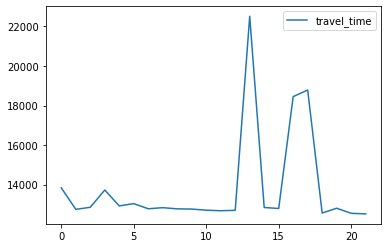

In [34]:
df_out.groupby(['date', 'origin', 'destination']).mean().reset_index().groupby(
    ['date']).sum()[['travel_time']].reset_index().sort_values(by = 'date').plot(y = 'travel_time')